In [49]:
import zipfile
import os
import pandas as pd
import numpy as np
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import PandasTools
from IPython.display import display
from joblib import Parallel, delayed
from rdkit import Chem
import subprocess
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem
from rdkit import DataStructs
import py3Dmol

In [50]:
Caffeine_molecular_formula = 'C8H10N4O2'

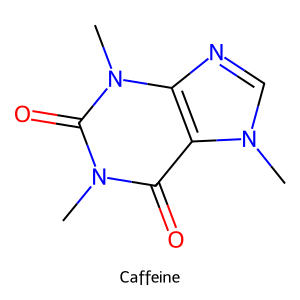

In [51]:
# Create a RDKit molecule object from the SMILES string of caffeine
caffeine_smiles = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"
mol = Chem.MolFromSmiles(caffeine_smiles)

# Generate a 2D depiction of the molecule
img = Draw.MolToImage(mol, legend="Caffeine" )

# Display the image
display(img)



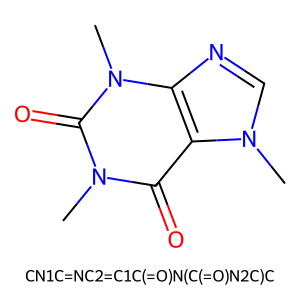

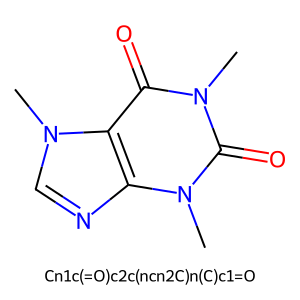

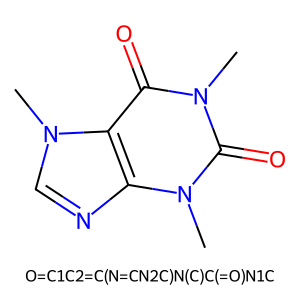

In [52]:
caffeine_smiles_1 = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"  # Original
caffeine_smiles_2 = "Cn1c(=O)c2c(ncn2C)n(C)c1=O"    # Alternative 1
caffeine_smiles_3 = "O=C1C2=C(N=CN2C)N(C)C(=O)N1C"  # Alternative 2

for smiles in [caffeine_smiles_1, caffeine_smiles_2, caffeine_smiles_3]:
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol, size=(300, 300), legend=f"{smiles}")
    display(img)


In [53]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw

# SMILES string for the molecule
for smiles in [caffeine_smiles_1, caffeine_smiles_2, caffeine_smiles_3]:
    mol = Chem.MolFromSmiles(smiles)
    mol_formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
    mol_weight = Descriptors.ExactMolWt(mol)
    num_atoms = mol.GetNumAtoms()
    num_bonds = mol.GetNumBonds()
    print(mol_formula, mol_weight, num_atoms, num_bonds)

C8H10N4O2 194.08037556 14 15
C8H10N4O2 194.08037556 14 15
C8H10N4O2 194.08037556 14 15


In [54]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import numpy as np
from joblib import Parallel, delayed

def generate_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # Create the Morgan fingerprint generator
        morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
        fp = morgan_generator.GetFingerprint(mol)

        # Convert to a bit vector
        bit_vector = np.array(list(fp.ToBitString())).astype(int)

        # Get sparse representation: indices of '1' bits
        sparse_representation = list(np.where(bit_vector == 1)[0])

        # Convert sparse representation to a string of space-separated indices
        sparse_representation_str = ' '.join(map(str, sparse_representation))
        
        return bit_vector, sparse_representation_str
    return None, None

# List of SMILES strings
caffeine_smiles_list = [caffeine_smiles_1, caffeine_smiles_2, caffeine_smiles_3]

# Parallel processing for fingerprint generation
num_cores = -1
results = Parallel(n_jobs=num_cores)(delayed(generate_fingerprint)(smiles) for smiles in caffeine_smiles_list)

# Unzip the results into two lists
bit_vectors, sparse_fingerprints = zip(*results)

# Print results
for i, (smiles, bit_vector, sparse_fingerprint) in enumerate(zip(caffeine_smiles_list, bit_vectors, sparse_fingerprints), 1):
    print(f"Caffeine SMILES {i}:")
    print(f"SMILES: {smiles}")
    print(f"Bit Vector: {bit_vector}")
    print(f"Sparse Fingerprint: {sparse_fingerprint}")
    print()

# Compare the bit vectors
are_unique = len(set(map(tuple, bit_vectors))) == len(bit_vectors)
print("Comparison of bit vectors:")
if are_unique:
    print("All three bit vectors are unique.")
else:
    print("Not all bit vectors are unique.")

# Detailed comparison
for i in range(len(bit_vectors)):
    for j in range(i+1, len(bit_vectors)):
        similarity = np.sum(bit_vectors[i] == bit_vectors[j]) / len(bit_vectors[i])
        print(f"Similarity between bit vector {i+1} and {j+1}: {similarity:.2%}")


Caffeine SMILES 1:
SMILES: CN1C=NC2=C1C(=O)N(C(=O)N2C)C
Bit Vector: [0 0 0 ... 0 0 0]
Sparse Fingerprint: 33 314 378 400 463 504 564 650 771 932 935 1024 1057 1145 1203 1258 1307 1354 1380 1409 1440 1452 1517 1696 1873

Caffeine SMILES 2:
SMILES: Cn1c(=O)c2c(ncn2C)n(C)c1=O
Bit Vector: [0 0 0 ... 0 0 0]
Sparse Fingerprint: 33 314 378 400 463 504 564 650 771 932 935 1024 1057 1145 1203 1258 1307 1354 1380 1409 1440 1452 1517 1696 1873

Caffeine SMILES 3:
SMILES: O=C1C2=C(N=CN2C)N(C)C(=O)N1C
Bit Vector: [0 0 0 ... 0 0 0]
Sparse Fingerprint: 33 314 378 400 463 504 564 650 771 932 935 1024 1057 1145 1203 1258 1307 1354 1380 1409 1440 1452 1517 1696 1873

Comparison of bit vectors:
Not all bit vectors are unique.
Similarity between bit vector 1 and 2: 100.00%
Similarity between bit vector 1 and 3: 100.00%
Similarity between bit vector 2 and 3: 100.00%


In [55]:
from rdkit import Chem
from rdkit.Chem import AllChem

def generate_ecfp4(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)

caffeine_smiles_1 = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"  # Original
caffeine_smiles_2 = "Cn1c(=O)c2c(ncn2C)n(C)c1=O"    # Alternative 1
caffeine_smiles_3 = "O=C1C2=C(N=CN2C)N(C)C(=O)N1C"  # Alternative 2

fp1 = generate_ecfp4(caffeine_smiles_1)
fp2 = generate_ecfp4(caffeine_smiles_2)
fp3 = generate_ecfp4(caffeine_smiles_3)

print(f"FP1 == FP2: {fp1 == fp2}")
print(f"FP1 == FP3: {fp1 == fp3}")
print(f"FP2 == FP3: {fp2 == fp3}")

FP1 == FP2: True
FP1 == FP3: True
FP2 == FP3: True


[23:19:15] DEPRECATION WARNING: please use MorganGenerator
[23:19:15] DEPRECATION WARNING: please use MorganGenerator
[23:19:15] DEPRECATION WARNING: please use MorganGenerator


In [56]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

def generate_ecfp4(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)

def compare_fingerprints(fp1, fp2):
    return 1 - (fp1 & fp2).GetNumOnBits() / (fp1 | fp2).GetNumOnBits()

caffeine_smiles_1 = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"  # Original
caffeine_smiles_2 = "Cn1c(=O)c2c(ncn2C)n(C)c1=O"    # Alternative 1
caffeine_smiles_3 = "O=C1C2=C(N=CN2C)N(C)C(=O)N1C"  # Alternative 2

fp1 = generate_ecfp4(caffeine_smiles_1)
fp2 = generate_ecfp4(caffeine_smiles_2)
fp3 = generate_ecfp4(caffeine_smiles_3)

print(f"FP1 vs FP2 difference: {compare_fingerprints(fp1, fp2)}")
print(f"FP1 vs FP3 difference: {compare_fingerprints(fp1, fp3)}")
print(f"FP2 vs FP3 difference: {compare_fingerprints(fp2, fp3)}")

# Demonstrating information loss
print("\nFingerprint to molecular formula:")
print(f"Number of 1s in FP1: {fp1.GetNumOnBits()}")
print(f"Total bits in fingerprint: {fp1.GetNumBits()}")

FP1 vs FP2 difference: 0.0
FP1 vs FP3 difference: 0.0
FP2 vs FP3 difference: 0.0

Fingerprint to molecular formula:
Number of 1s in FP1: 25
Total bits in fingerprint: 2048


[23:19:15] DEPRECATION WARNING: please use MorganGenerator
[23:19:15] DEPRECATION WARNING: please use MorganGenerator
[23:19:15] DEPRECATION WARNING: please use MorganGenerator


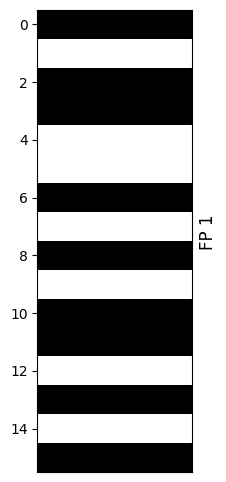

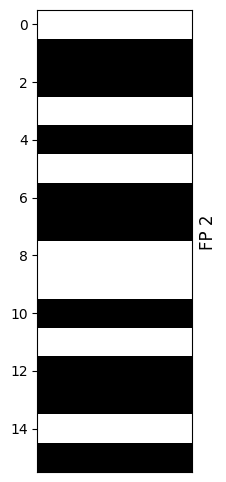

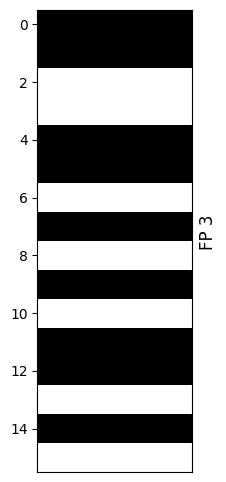

In [68]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bit_vector(bit_vector, title):
    plt.figure(figsize=(2, 6))
    plt.imshow(np.array(bit_vector).reshape(-1, 1), cmap='binary', aspect='auto')
    plt.title(title, rotation='vertical', x=1.1, y=0.5, va='center')
    plt.xticks([])

# Generate unique bit vectors for visualization
fp1_short = [1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1]
fp2_short = [0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1]
fp3_short = [1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0]

# Plot the bit vectors
plot_bit_vector(fp1_short, 'FP 1')
plt.show()

plot_bit_vector(fp2_short, 'FP 2')
plt.show()

plot_bit_vector(fp3_short, 'FP 3')
plt.show()


In [2]:
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display, Image as IPyImage

class BitVectorVisualizer:
    def __init__(self, size=8):
        self.size = size
        self.square_size = 50  # pixels
        self.bits = np.random.randint(0, 2, size)  # Random initial bit vector
        
    def create_image(self):
        # Calculate image dimensions
        width = self.square_size * self.size
        height = self.square_size
        
        # Create a white image
        image = Image.new('RGB', (width, height), 'white')
        draw = ImageDraw.Draw(image)
        
        # Draw squares for each bit
        for i in range(self.size):
            x = i * self.square_size
            y = 0
            
            # Draw square outline
            draw.rectangle(
                [x, y, x + self.square_size, y + self.square_size],
                outline='black',
                width=2
            )
            
            # Fill square if bit is 1
            if self.bits[i]:
                draw.rectangle(
                    [x, y, x + self.square_size, y + self.square_size],
                    fill='black'
                )
        
        return image
    
    def display(self):
        """Display the bit vector in the notebook"""
        image = self.create_image()
        display(IPyImage(data=image._repr_png_()))
        print(f"Bits: {self.get_bits()}")
    
    def flip_bit(self, position):
        """Flip the bit at the specified position (0-based indexing)"""
        if 0 <= position < self.size:
            self.bits[position] = 1 - self.bits[position]
            self.display()  # Automatically show the result
        else:
            raise ValueError(f"Position must be between 0 and {self.size-1}")
    
    def get_bits(self):
        """Return current bit vector as a list"""
        return self.bits.tolist()
    
    def set_bits(self, new_bits):
        """Set the bit vector to a specific configuration"""
        if len(new_bits) != self.size:
            raise ValueError(f"New bits must have length {self.size}")
        self.bits = np.array(new_bits)
        self.display()  # Automatically show the result

In [6]:
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display, Image as IPyImage

class BitVectorVisualizer:
    def __init__(self, size=4):  # Changed to 4 bits
        self.size = size
        self.square_size = 50  # pixels
        self.bits = np.random.randint(0, 2, size)  # Random initial bit vector
        self.original_bits = self.bits.copy()  # Store original bits
        self.last_flipped = None  # Track last flipped position
        
    def create_image(self):
        # Calculate image dimensions
        width = self.square_size * self.size
        height = self.square_size
        
        # Create a white image
        image = Image.new('RGB', (width, height), 'white')
        draw = ImageDraw.Draw(image)
        
        # Draw squares for each bit
        for i in range(self.size):
            x = i * self.square_size
            y = 0
            
            # Draw square outline
            outline_color = 'blue' if i == self.last_flipped else 'black'
            outline_width = 3 if i == self.last_flipped else 2
            
            # Fill square if bit is 1
            if self.bits[i]:
                draw.rectangle(
                    [x, y, x + self.square_size, y + self.square_size],
                    fill='black'
                )
            
            # Draw outline
            draw.rectangle(
                [x, y, x + self.square_size, y + self.square_size],
                outline=outline_color,
                width=outline_width
            )
        
        return image
    
    def display(self):
        """Display the bit vector in the notebook"""
        image = self.create_image()
        display(IPyImage(data=image._repr_png_()))
        print(f"Bits: {self.get_bits()}")
    
    def flip_bit(self, position):
        """Flip the bit at the specified position (0-based indexing)"""
        if 0 <= position < self.size:
            # Reset all bits to original state
            self.bits = self.original_bits.copy()
            # Flip only the specified bit
            self.bits[position] = 1 - self.original_bits[position]
            self.last_flipped = position  # Track the flipped position
            self.display()  # Automatically show the result
        else:
            raise ValueError(f"Position must be between 0 and {self.size-1}")
    
    def get_bits(self):
        """Return current bit vector as a list"""
        return self.bits.tolist()
    
    def set_bits(self, new_bits):
        """Set the bit vector to a specific configuration"""
        if len(new_bits) != self.size:
            raise ValueError(f"New bits must have length {self.size}")
        self.bits = np.array(new_bits)
        self.original_bits = self.bits.copy()  # Update original bits
        self.last_flipped = None  # Reset last flipped position
        self.display()  # Automatically show the result


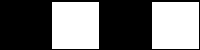

Bits: [1, 0, 1, 0]


In [8]:
viz = BitVectorVisualizer()

viz.display()



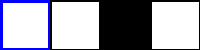

Bits: [0, 0, 1, 0]


In [9]:
viz.flip_bit(0)

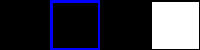

Bits: [1, 1, 1, 0]


In [10]:
viz.flip_bit(1)

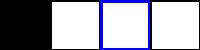

Bits: [1, 0, 0, 0]


In [11]:
viz.flip_bit(2)

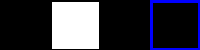

Bits: [1, 0, 1, 1]


In [12]:
viz.flip_bit(3)